In [2]:
%load_ext autoreload
%autoreload 2

 
import sys
sys.path.append("..")

# Importing the LLM models and the necessary modules

In [ ]:
from langchain_mistralai import ChatMistralAI
from langchain_mistralai import MistralAIEmbeddings

mistral_api_key = "##"
mistral_llm_model = ChatMistralAI(
    api_key = mistral_api_key,
    model="mistral-large-latest",
    temperature=0,
    max_retries=2,
)


mistral_embeddings_model = MistralAIEmbeddings(
    model="mistral-embed",
    api_key = mistral_api_key
)

In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

openai_api_key = "##"

openai_llm_model = ChatOpenAI(
    api_key = openai_api_key,
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

openai_embeddings_model = OpenAIEmbeddings(
    api_key = openai_api_key ,
    model="text-embedding-3-large",
)


In [4]:
from atom.utils import LangchainOutputParser

lg = LangchainOutputParser(llm_model=openai_llm_model, embeddings_model=openai_embeddings_model)

# Loading the datasets

In [3]:
import pandas as pd
import ast

def recover_list_dfs(df):
    for col in df.columns:
        if df[col].dtype == object:  # Ensure we only process object (string) columns
            first_valid_index = df[col].first_valid_index()
            if first_valid_index is not None and isinstance(df[col].loc[first_valid_index], str):
                first_value = df[col].loc[first_valid_index].strip()  # Strip any whitespace
                if first_value.startswith("[") and first_value.endswith("]"):  # Ensure it's a list format
                    def safe_eval(x):
                        try:
                            return ast.literal_eval(x) if isinstance(x, str) else x
                        except (SyntaxError, ValueError) as e:
                            print(f"Skipping invalid value in column '{col}': {x} -> {e}")
                            return None  # Return None for problematic values
                    df[col] = df[col].apply(safe_eval)
                    
    return df
    

df_news = recover_list_dfs(pd.read_excel("../datasets/news/df_news_all_llms_eval.xlsx"))
df_abstracts = recover_list_dfs(pd.read_excel("../datasets/abstracts/df_abstracts_all_llms_eval.xlsx"))

Skipping invalid value in column 'triplets_from_cumulatives_o3mini': [('researchers', 'used', 'high‐resolution imaging', [], []), ('researchers', 'used', 'molecular assays', [], []), ('high‐resolution imaging', 'used_in', 'study on neural plasticity', [], []), ('molecular assays', 'used_in', 'study on neural plasticity', [], []), ('activity‐dependent modulation', 'involves', 'receptor trafficking', [], []), ('receptor trafficking', 'maintains', 'synaptic efficacy', [], []), ('disruptions in receptor trafficking', 'underlie', 'cognitive deficits', [], []), ('cognitive deficits', 'observed_in', 'neurodegenerative conditions', [], []), ('climate scientists', 'used', 'advanced computational models', [], []), ('advanced computational models', 'developed', 'novel framework', [], []), ('novel framework', 'simulates', 'feedback loops', [], []), ('feedback loops', 'involve', 'ocean‐atmosphere interactions', [], []), ('feedback loops', 'involve', 'biospheric responses', [], []), ('novel framewor

# Exhaustivity and Best chunking size

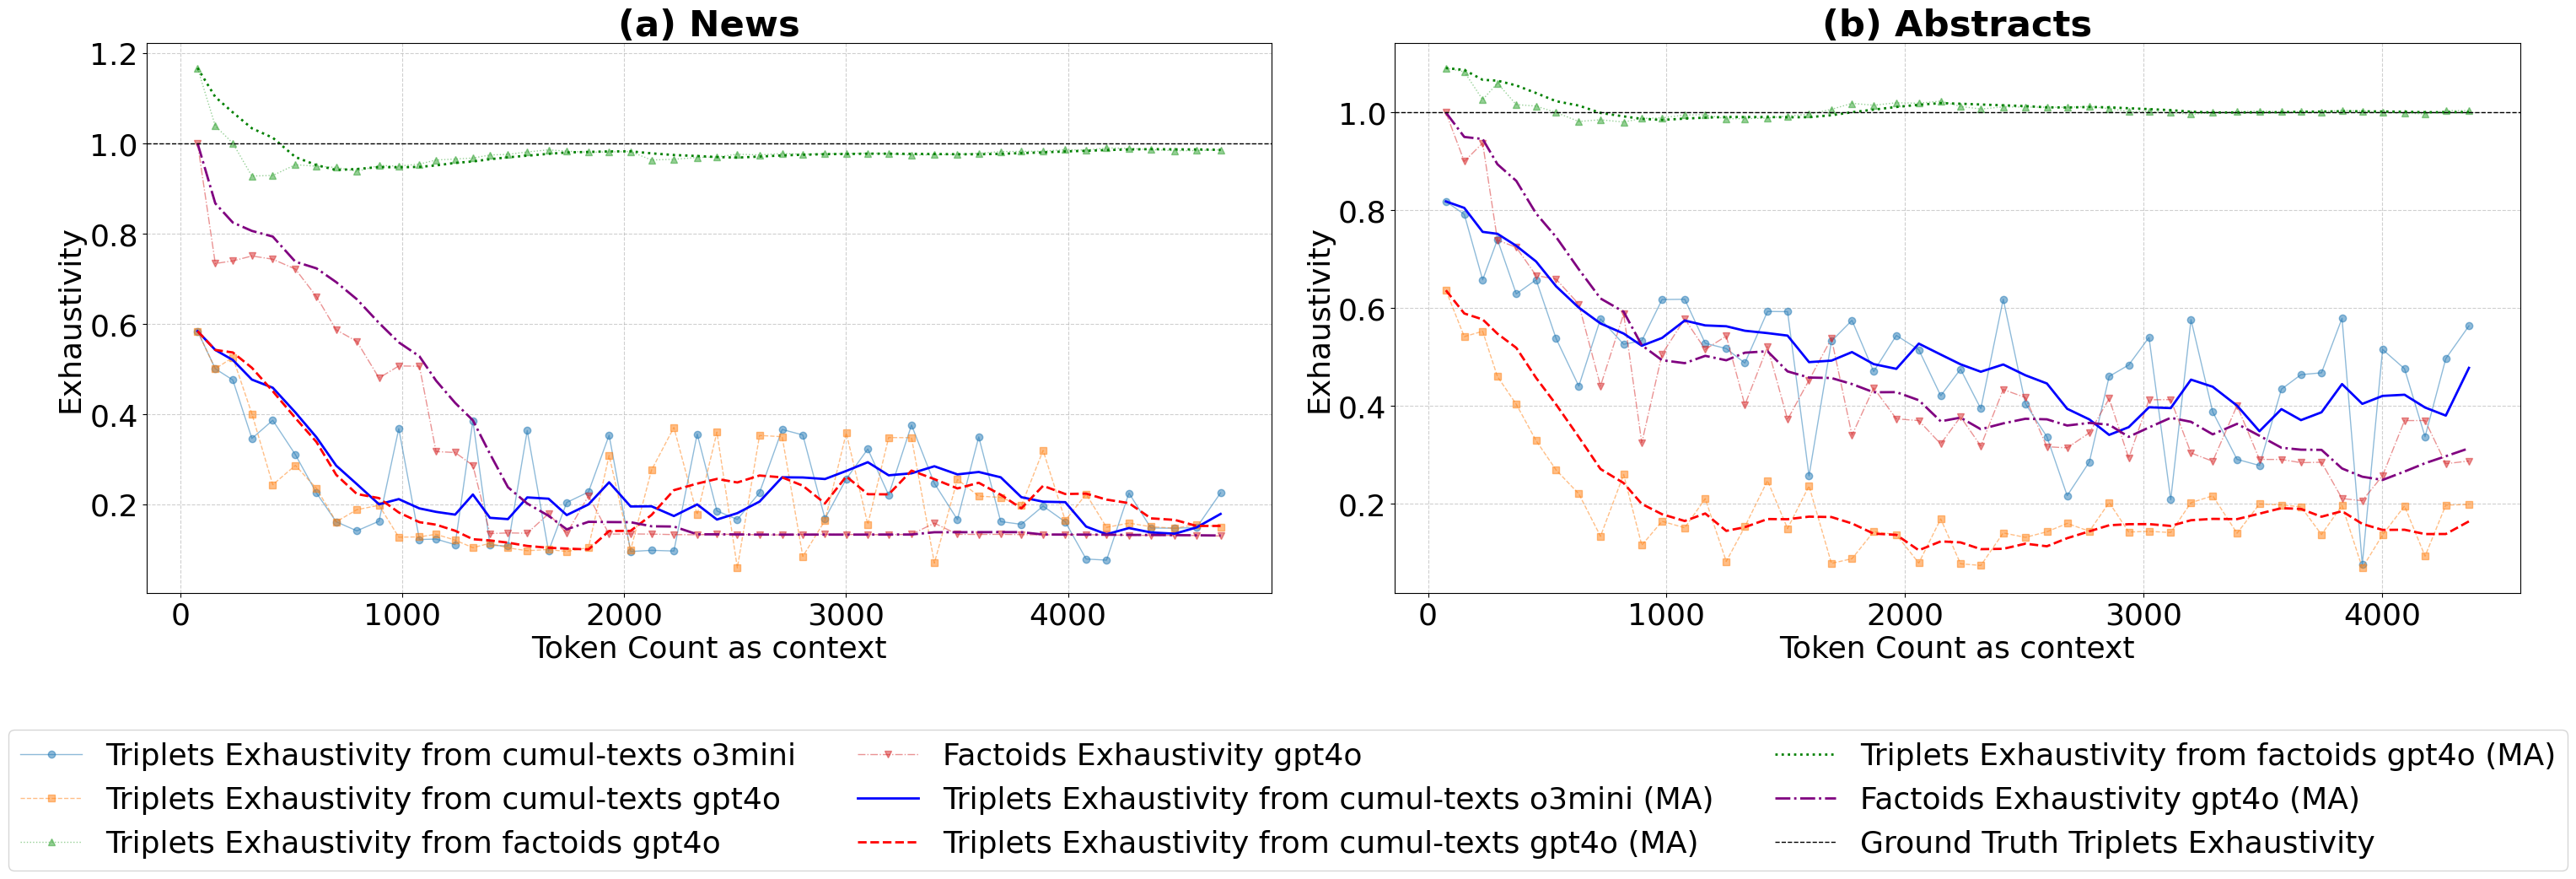

In [4]:
import matplotlib.pyplot as plt

# Update global font size
plt.rcParams.update({'font.size': 26})

# Define moving average window size
window_size = 5


# For df_news:
df_news["triples_exhaustivity_o3mini_ma"] = df_news["triples_exhaustivity_o3mini"].rolling(window=window_size, min_periods=1).mean()
df_news["triples_exhaustivity_gpt4o_ma"] = df_news["triples_exhaustivity_gpt4o"].rolling(window=window_size, min_periods=1).mean()
df_news["triplets_exhaustivity_ma"] = df_news["triplets_exhaustivity"].rolling(window=window_size, min_periods=1).mean()
df_news["factoids_exhaustivity_ma"] = df_news["factoids_exhaustivity"].rolling(window=window_size, min_periods=1).mean()

# For df_abstracts:
df_abstracts["triples_exhaustivity_o3mini_ma"] = df_abstracts["triples_exhaustivity_o3mini"].rolling(window=window_size, min_periods=1).mean()
df_abstracts["triples_exhaustivity_gpt4o_ma"] = df_abstracts["triples_exhaustivity_gpt4o"].rolling(window=window_size, min_periods=1).mean()
df_abstracts["triplets_exhaustivity_ma"] = df_abstracts["triplets_exhaustivity"].rolling(window=window_size, min_periods=1).mean()
df_abstracts["factoids_exhaustivity_ma"] = df_abstracts["factoids_exhaustivity"].rolling(window=window_size, min_periods=1).mean()

# --- Create Figure with Two Subplots (News and Abstracts) ---

fig, axes = plt.subplots(1, 2, figsize=(30, 9))

# --- Plot for df_news ---
axes[0].plot(df_news["token_count"], df_news["triples_exhaustivity_o3mini"],
             label="Triples Exhaustivity o3mini", linewidth=1, marker='o', alpha=0.5)
axes[0].plot(df_news["token_count"], df_news["triples_exhaustivity_gpt4o"],
             label="Triples Exhaustivity gpt4o", linewidth=1, linestyle="dashed", marker='s', alpha=0.5)
axes[0].plot(df_news["token_count"], df_news["triplets_exhaustivity"],
             label="Triplets Exhaustivity", linewidth=1, linestyle="dotted", marker='^', alpha=0.5)
axes[0].plot(df_news["token_count"], df_news["factoids_exhaustivity"],
             label="Factoids Exhaustivity", linewidth=1, linestyle="dashdot", marker='v', alpha=0.5)

# Plot moving averages
axes[0].plot(df_news["token_count"], df_news["triples_exhaustivity_o3mini_ma"],
             label="Triples Exhaustivity o3mini (MA)", linewidth=2, color='blue')
axes[0].plot(df_news["token_count"], df_news["triples_exhaustivity_gpt4o_ma"],
             label="Triples Exhaustivity gpt4o (MA)", linewidth=2, linestyle="dashed", color='red')
axes[0].plot(df_news["token_count"], df_news["triplets_exhaustivity_ma"],
             label="Triplets Exhaustivity (MA)", linewidth=2, linestyle="dotted", color='green')
axes[0].plot(df_news["token_count"], df_news["factoids_exhaustivity_ma"],
             label="Factoids Exhaustivity (MA)", linewidth=2, linestyle="dashdot", color='purple')

axes[0].axhline(y=1, color='black', linestyle='--', linewidth=1,
                label="Ground Truth Exhaustivity")
axes[0].set_xlabel("Token Count as context")
axes[0].set_ylabel("Exhaustivity")
axes[0].set_title("(a) News", fontweight='bold')
axes[0].grid(True, linestyle="--", alpha=0.6)

# --- Plot for df_abstracts ---
axes[1].plot(df_abstracts["token_count"], df_abstracts["triples_exhaustivity_o3mini"],
             label="Triplets Exhaustivity from cumul-texts o3mini", linewidth=1, marker='o', alpha=0.5)
axes[1].plot(df_abstracts["token_count"], df_abstracts["triples_exhaustivity_gpt4o"],
             label="Triplets Exhaustivity from cumul-texts gpt4o", linewidth=1, linestyle="dashed", marker='s', alpha=0.5)
axes[1].plot(df_abstracts["token_count"], df_abstracts["triplets_exhaustivity"],
             label="Triplets Exhaustivity from factoids gpt4o", linewidth=1, linestyle="dotted", marker='^', alpha=0.5)
axes[1].plot(df_abstracts["token_count"], df_abstracts["factoids_exhaustivity"],
             label="Factoids Exhaustivity gpt4o", linewidth=1, linestyle="dashdot", marker='v', alpha=0.5)

# Plot moving averages
axes[1].plot(df_abstracts["token_count"], df_abstracts["triples_exhaustivity_o3mini_ma"],
             label="Triplets Exhaustivity from cumul-texts o3mini (MA)", linewidth=2, color='blue')
axes[1].plot(df_abstracts["token_count"], df_abstracts["triples_exhaustivity_gpt4o_ma"],
             label="Triplets Exhaustivity from cumul-texts gpt4o (MA)", linewidth=2, linestyle="dashed", color='red')
axes[1].plot(df_abstracts["token_count"], df_abstracts["triplets_exhaustivity_ma"],
             label="Triplets Exhaustivity from factoids gpt4o (MA)", linewidth=2, linestyle="dotted", color='green')
axes[1].plot(df_abstracts["token_count"], df_abstracts["factoids_exhaustivity_ma"],
             label="Factoids Exhaustivity gpt4o (MA)", linewidth=2, linestyle="dashdot", color='purple')

axes[1].axhline(y=1, color='black', linestyle='--', linewidth=1,
                label="Ground Truth Triplets Exhaustivity")
axes[1].set_xlabel("Token Count as context")
axes[1].set_ylabel("Exhaustivity")
axes[1].set_title("(b) Abstracts", fontweight='bold')
axes[1].grid(True, linestyle="--", alpha=0.6)

# --- Consolidate Legend ---
for ax in axes:
    ax.legend().remove()  # remove individual legends
handles, labels = axes[1].get_legend_handles_labels()  # assume same labels in both subplots
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=26,
           bbox_to_anchor=(0.5, -0.2))

plt.tight_layout(rect=[0, 0.05, 1, 1])  # adjust layout to accommodate the legend
fig.savefig("exhaustivity_plots.pdf", bbox_inches='tight')
plt.show()